# Stynthetic Tags Pretraining
 
Used to predict sentiment tags using a following sentence of "I feel ____" blank

This notebook attempts to do sentiment classification using a Causal Lanugage Model, using few-shot learning, based on the ideas in https://aclanthology.org/2021.eacl-main.20.pdf

Reference Notebooks:
https://github.com/huggingface/notebooks/blob/master/transformers_doc/task_summary.ipynb
 

## Setup host


In [1]:
# Transformers installation
#! pip install transformers datasets

In [2]:
import transformers

print(transformers.__version__)
from transformers import BertTokenizer, TFBertModel


4.18.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
# connect to drive
from google.colab import drive  
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## Load and prepare synthetic training data

### Specify canonical labels


In [5]:
LABELS = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral',
]


In [6]:



##datasets = load_dataset("csv", 
#                         data_files={"train": "/content/drive/My Drive/Colab Notebooks/266-NLP-data/strat_training.csv",
#                                     "validation": "/content/drive/My Drive/Colab Notebooks/266-NLP-data/strat_val.csv",
#                                     "test": "/content/drive/My Drive/Colab Notebooks/266-NLP-data/strat_test.csv"})

#print(datasets)
pretrain = pd.read_csv("/content/drive/My Drive/266-NLP-data/100K_results_model_generated.csv")
train = pd.read_csv("/content/drive/My Drive/266-NLP-data/strat_training.csv")
val = pd.read_csv("/content/drive/My Drive/266-NLP-data/strat_val.csv")
test = pd.read_csv("/content/drive/My Drive/266-NLP-data/strat_test.csv")



### fix column names


In [7]:

train=train.rename(columns={" amusement": "amusement", " anger": "anger", " annoyance": "annoyance", " approval": "approval",
                       " caring": "caring", " confusion": "confusion", " curiosity": "curiosity", " desire":"desire", " disappointment":"disappointment",
                       " disapproval": "disapproval", " disgust": "disgust", " embarrassment":"embarrassment",
                       " excitement": "excitement", " fear": "fear", " gratitude": "gratitude", " grief": "grief", " joy": "joy",
                       " love": "love", " nervousness": "nervousness", " optimism": "optimism", " pride": "pride", " realization": "realization",
                       " relief": "relief", " sadness":"sadness", " surprise": "surprise"," neutral": "neutral"})
test=test.rename(columns={" amusement": "amusement", " anger": "anger", " annoyance": "annoyance", " approval": "approval",
                       " caring": "caring", " confusion": "confusion", " curiosity": "curiosity", " desire":"desire", " disappointment":"disappointment",
                       " disapproval": "disapproval", " disgust": "disgust", " embarrassment":"embarrassment",
                       " excitement": "excitement", " fear": "fear", " gratitude": "gratitude", " grief": "grief", " joy": "joy",
                       " love": "love", " nervousness": "nervousness", " optimism": "optimism", " pride": "pride", " realization": "realization",
                       " relief": "relief", " sadness":"sadness", " surprise": "surprise"," neutral": "neutral"})
val=val.rename(columns={" amusement": "amusement", " anger": "anger", " annoyance": "annoyance", " approval": "approval",
                       " caring": "caring", " confusion": "confusion", " curiosity": "curiosity", " desire":"desire", " disappointment":"disappointment",
                       " disapproval": "disapproval", " disgust": "disgust", " embarrassment":"embarrassment",
                       " excitement": "excitement", " fear": "fear", " gratitude": "gratitude", " grief": "grief", " joy": "joy",
                       " love": "love", " nervousness": "nervousness", " optimism": "optimism", " pride": "pride", " realization": "realization",
                       " relief": "relief", " sadness":"sadness", " surprise": "surprise"," neutral": "neutral"})

train_str = train[['target_string']].to_numpy() 
test_str = test[['target_string']].to_numpy() 
val_str = val[['target_string']].to_numpy()


train_label = train[LABELS].to_numpy()

test_label = test[LABELS].to_numpy() 

val_label = val[LABELS].to_numpy() 

In [8]:
train_str
train_label

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
# setup pretraining data
from sklearn.model_selection import train_test_split

pretrain_str = pretrain[['string']].to_numpy() 

# this needs to be coverted to 0/1
pretrain_label = np.round(pretrain[LABELS].to_numpy(),0).astype(int)
pretrain_train_str,  pretrain_val_str,pretrain_train_label, pretrain_val_label = train_test_split(pretrain_str, pretrain_label, test_size = .1)


In [10]:
print(pretrain_train_str.shape, pretrain_val_str.shape)


(90000, 1) (10000, 1)


### Standarize Tokenization

In [11]:
def tokenize(tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')):
  tokenize.max_length = 80

  tokenize.x_train = tokenizer([str(x) for x in train_str],
                max_length=tokenize.max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')
  tokenize.y_train = train_label


  tokenize.x_test = tokenizer([str(x) for x in test_str],
                max_length=tokenize.max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')
  tokenize.y_test = test_label


  tokenize.x_val = tokenizer([str(x) for x in val_str],
                max_length=tokenize.max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')
  tokenize.y_val = val_label

  tokenize.x_pretrain_train = tokenizer([str(x)  for x in pretrain_train_str],
                max_length=tokenize.max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')
  tokenize.y_pretrain_train = pretrain_train_label

  tokenize.x_pretrain_val = tokenizer([str(x)  for x in pretrain_val_str],
                max_length=tokenize.max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')
  tokenize.y_pretrain_val = pretrain_val_label

  return tokenize.x_train, tokenize.y_train, tokenize.x_test, tokenize.y_test,
  tokenize.x_val, tokenize.y_val, tokenize.x_pretrain, tokenize.y_pretrain



## Functions shared by model runs

### Build custom F1 function


In [12]:
from keras import backend as K

def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Base classification model


In [13]:
def rob_create_classification_model(base_model, hidden_size = 200, 
                                train_layers = -1, 
                                optimizer=tf.keras.optimizers.Adam()):
    """
    Build a model with RoBERTa
    """

    input_ids = tf.keras.layers.Input(shape=(tokenize.max_length,), dtype=tf.int32, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(tokenize.max_length,), dtype=tf.int32, name='attention_mask_layer')

    rob_inputs = {'input_ids': input_ids,
                  'attention_mask': attention_mask}


    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in base_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False


    rob_out = base_model(rob_inputs)


    hidden = tf.keras.layers.Dense(hidden_size, name='hidden_layer')(rob_out[1])

    classification = tf.keras.layers.Dense(28, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], 
                                          outputs=[classification])
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    
    classification_model.compile(optimizer=optimizer,
                                 loss = loss,
                                 metrics=[tf.keras.metrics.BinaryAccuracy('accuracy'), 
                                          tf.keras.metrics.Precision(), 
                                          tf.keras.metrics.Recall(), 
                                          custom_f1])


    return classification_model

### Pretraining fit execution

In [14]:
def rob_fit_synth_pretrain_model(model,train_x, train_y,x_test,y_test, epoch_num = 15, batch_num = 53, learning = 0.001, layers=-1):
    """
    Fit, evaulate, and plot the model's F1 scores
    """
    
    #create and fit model
    classification_model = rob_create_classification_model(model,train_layers=layers,
                                                           optimizer=tf.keras.optimizers.Adam(learning))

    history = classification_model.fit([train_x.input_ids, train_x.attention_mask],
                                       train_y,
                                       validation_data=([x_test.input_ids, x_test.attention_mask],
                                       y_test),
                                       epochs = epoch_num,
                                       batch_size = batch_num)

    #plot results
    f1_train = history.history['custom_f1']
    f1_val = history.history['val_custom_f1']
    epochs = range(1,(epoch_num + 1))
    plt.plot(epochs, f1_train, label='Training F1 Score')
    plt.plot(epochs, f1_val, label='Validation F1 Score')
    plt.title('Training and Validation F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    
    return classification_model

### Pretraining eval execution


In [15]:
def rob_fit_eval_model(model,
                       x_train,y_train,
                       x_val,y_val, 
                       x_test,y_test,
                       epoch_num = 15, 
                       batch_num = 53):
    """
    Fit, evaulate, and plot the model's F1 scores
    """
    
  
    #create and fit model
    history = model.fit([x_train.input_ids, x_train.attention_mask],
                         y_train,
                         validation_data=([x_val.input_ids, x_val.attention_mask],
                         y_val),
                         epochs = epoch_num,
                         batch_size = batch_num)

    #plot results
    f1_train = history.history['custom_f1']
    f1_val = history.history['val_custom_f1']
    epochs = range(1,(epoch_num + 1))
    plt.plot(epochs, f1_train, label='Training F1 Score')
    plt.plot(epochs, f1_val, label='Validation F1 Score')
    plt.title('Training and Validation F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    
    return model.evaluate(x=[x_test.input_ids, x_test.attention_mask], y = y_test,  return_dict=True)
    return plt

## Run with raw roberta base

### Load base model


In [16]:
from transformers import  TFRobertaModel, AutoTokenizer

base_model = TFRobertaModel.from_pretrained('roberta-base')
tokenizer = AutoTokenizer.from_pretrained("roberta-base")



Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [17]:
tokenize()

({'input_ids': <tf.Tensor: shape=(1604, 80), dtype=int32, numpy=
 array([[ 101, 1031, 1005, ...,    0,    0,    0],
        [ 101, 1031, 1000, ...,    0,    0,    0],
        [ 101, 1031, 1000, ...,    0,    0,    0],
        ...,
        [ 101, 1031, 1000, ...,    0,    0,    0],
        [ 101, 1031, 1005, ...,    0,    0,    0],
        [ 101, 1031, 1000, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1604, 80), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1604, 80), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>},
 array([[

In [18]:
base_model.summary()

Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124645632 
 )                                                               
                                                                 
Total params: 124,645,632
Trainable params: 124,645,632
Non-trainable params: 0
_________________________________________________________________


### Pretrain with synthetic strings

Epoch 1/10
1699/1699 [==============================] - 706s 411ms/step - loss: 0.0238 - accuracy: 0.9941 - precision: 0.9094 - recall: 0.9225 - custom_f1: 0.9268 - val_loss: 0.0127 - val_accuracy: 0.9961 - val_precision: 0.9541 - val_recall: 0.9323 - val_custom_f1: 0.9430
Epoch 2/10
1699/1699 [==============================] - 696s 410ms/step - loss: 0.0103 - accuracy: 0.9966 - precision: 0.9494 - recall: 0.9547 - custom_f1: 0.9519 - val_loss: 0.0085 - val_accuracy: 0.9970 - val_precision: 0.9373 - val_recall: 0.9778 - val_custom_f1: 0.9570
Epoch 3/10
1699/1699 [==============================] - 696s 409ms/step - loss: 0.0083 - accuracy: 0.9971 - precision: 0.9539 - recall: 0.9630 - custom_f1: 0.9584 - val_loss: 0.0074 - val_accuracy: 0.9971 - val_precision: 0.9589 - val_recall: 0.9572 - val_custom_f1: 0.9579
Epoch 4/10
1699/1699 [==============================] - 695s 409ms/step - loss: 0.0076 - accuracy: 0.9972 - precision: 0.9557 - recall: 0.9654 - custom_f1: 0.9605 - val_loss: 0.0

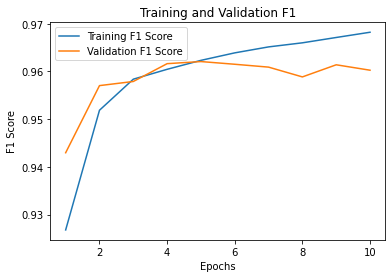

In [19]:

pretrain_model = rob_fit_synth_pretrain_model(base_model,
                                              tokenize.x_pretrain_train,tokenize.y_pretrain_train,
                                              tokenize.x_pretrain_val,tokenize.y_pretrain_val,
                                              epoch_num = 10, learning = 0.00005,layers=2)

In [22]:
pretrain_model.summary()

drive.mount('/content/drive',force_remount=True)

pretrain_model.save("/content/drive/My Drive/266-NLP-data/roberta_synth_pretrained_100K")

drive.flush_and_unmount()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 80)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 80)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['attention_mask_layer[0][0]',   
 el)                            thPoolingAndCrossAt               'input_ids_layer[0][0]']        
                                tentions(last_hidde                                           

INFO:tensorflow:Assets written to: /content/drive/My Drive/266-NLP-data/roberta_synth_pretrained_100K/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/266-NLP-data/roberta_synth_pretrained_100K/assets


In [23]:
print(pretrain_model.evaluate(x=[tokenize.x_test.input_ids, tokenize.x_test.attention_mask], y = tokenize.y_test,  return_dict=True))

print(pretrain_model.evaluate(x=[tokenize.x_train.input_ids,tokenize. x_train.attention_mask], y = tokenize.y_train,  return_dict=True))

print(pretrain_model.evaluate(x=[tokenize.x_val.input_ids,tokenize. x_val.attention_mask], y = tokenize.y_val,  return_dict=True))

7/7 [==============================] - 1s 151ms/step - loss: 0.6624 - accuracy: 0.9463 - precision: 0.3958 - recall: 0.3065 - custom_f1: 0.2985
{'loss': 0.6624208688735962, 'accuracy': 0.946336030960083, 'precision': 0.3958333432674408, 'recall': 0.30645161867141724, 'custom_f1': 0.29848185181617737}
51/51 [==============================] - 9s 178ms/step - loss: 0.7185 - accuracy: 0.9399 - precision: 0.3548 - recall: 0.2548 - custom_f1: 0.2914
{'loss': 0.7185176610946655, 'accuracy': 0.9398602843284607, 'precision': 0.3547573983669281, 'recall': 0.25475114583969116, 'custom_f1': 0.2913542091846466}
7/7 [==============================] - 1s 175ms/step - loss: 0.7929 - accuracy: 0.9355 - precision: 0.3333 - recall: 0.2253 - custom_f1: 0.2881
{'loss': 0.7928969264030457, 'accuracy': 0.9355010390281677, 'precision': 0.3333333432674408, 'recall': 0.22525596618652344, 'custom_f1': 0.2881138324737549}


### Fine tune train on our tagged data


Epoch 1/50
31/31 [==============================] - 13s 412ms/step - loss: 0.2306 - accuracy: 0.9469 - precision: 0.3377 - recall: 0.0814 - custom_f1: 0.1182 - val_loss: 0.1891 - val_accuracy: 0.9481 - val_precision: 1.0000 - val_recall: 0.0034 - val_custom_f1: 0.0328
Epoch 2/50
31/31 [==============================] - 13s 414ms/step - loss: 0.1691 - accuracy: 0.9509 - precision: 0.8000 - recall: 0.0036 - custom_f1: 0.0299 - val_loss: 0.1810 - val_accuracy: 0.9485 - val_precision: 1.0000 - val_recall: 0.0102 - val_custom_f1: 0.0453
Epoch 3/50
31/31 [==============================] - 13s 409ms/step - loss: 0.1657 - accuracy: 0.9512 - precision: 0.6863 - recall: 0.0158 - custom_f1: 0.0527 - val_loss: 0.1802 - val_accuracy: 0.9486 - val_precision: 1.0000 - val_recall: 0.0137 - val_custom_f1: 0.0513
Epoch 4/50
31/31 [==============================] - 13s 404ms/step - loss: 0.1624 - accuracy: 0.9513 - precision: 0.6944 - recall: 0.0226 - custom_f1: 0.0706 - val_loss: 0.1794 - val_accuracy: 

{'accuracy': 0.9387490749359131,
 'custom_f1': 0.19072745740413666,
 'loss': 0.3983008563518524,
 'precision': 0.2681564390659332,
 'recall': 0.19354838132858276}

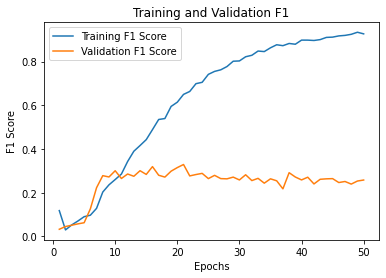

In [24]:
# reset epocs ~ 50
rob_fit_eval_model(pretrain_model,
                   tokenize.x_train,tokenize.y_train,
                   tokenize.x_val, tokenize.y_val,
                   tokenize.x_test, tokenize.y_test,
                   epoch_num = 50)

In [25]:
print(pretrain_model.evaluate(x=[tokenize.x_test.input_ids, tokenize.x_test.attention_mask], y = tokenize.y_test,  return_dict=True))

print(pretrain_model.evaluate(x=[tokenize.x_train.input_ids,tokenize. x_train.attention_mask], y = tokenize.y_train,  return_dict=True))
print(pretrain_model.evaluate(x=[tokenize.x_val.input_ids,tokenize. x_val.attention_mask], y = tokenize.y_val,  return_dict=True))

7/7 [==============================] - 1s 150ms/step - loss: 0.3983 - accuracy: 0.9387 - precision: 0.2682 - recall: 0.1935 - custom_f1: 0.1907
{'loss': 0.3983008563518524, 'accuracy': 0.9387490749359131, 'precision': 0.2681564390659332, 'recall': 0.19354838132858276, 'custom_f1': 0.19072745740413666}
51/51 [==============================] - 9s 171ms/step - loss: -0.0409 - accuracy: 0.9982 - precision: 0.9906 - recall: 0.9986 - custom_f1: 0.9948
{'loss': -0.0408942885696888, 'accuracy': 0.9981741309165955, 'precision': 0.9905744791030884, 'recall': 0.9986425042152405, 'custom_f1': 0.9948282241821289}
7/7 [==============================] - 1s 157ms/step - loss: 0.4224 - accuracy: 0.9366 - precision: 0.3370 - recall: 0.2082 - custom_f1: 0.2690
{'loss': 0.4223991930484772, 'accuracy': 0.9365671873092651, 'precision': 0.33701658248901367, 'recall': 0.2081911265850067, 'custom_f1': 0.26896336674690247}


## Run with Spotify MLM pretrained Roberta

### Load base model

In [27]:
drive.mount('/content/drive',force_remount=True)
MLM_model = TFRobertaModel.from_pretrained("/content/drive/MyDrive/Colab Notebooks/266-NLP-data/roberta_pretrained_500000_10epoch")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

tokenize()


Mounted at /content/drive


Some layers from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/266-NLP-data/roberta_pretrained_500000_10epoch were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/266-NLP-data/roberta_pretrained_500000_10epoch and are newly initialized: ['roberta/pooler/dense/kernel:0', 'roberta/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

({'input_ids': <tf.Tensor: shape=(1604, 80), dtype=int32, numpy=
 array([[ 101, 1031, 1005, ...,    0,    0,    0],
        [ 101, 1031, 1000, ...,    0,    0,    0],
        [ 101, 1031, 1000, ...,    0,    0,    0],
        ...,
        [ 101, 1031, 1000, ...,    0,    0,    0],
        [ 101, 1031, 1005, ...,    0,    0,    0],
        [ 101, 1031, 1000, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1604, 80), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1604, 80), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>},
 array([[

### Pretrain with synthetic strings

Epoch 1/10


1699/1699 [==============================] - 715s 416ms/step - loss: 0.0235 - accuracy: 0.9944 - precision_1: 0.9113 - recall_1: 0.9308 - custom_f1: 0.9314 - val_loss: 0.0105 - val_accuracy: 0.9965 - val_precision_1: 0.9582 - val_recall_1: 0.9399 - val_custom_f1: 0.9489
Epoch 2/10
1699/1699 [==============================] - 706s 416ms/step - loss: 0.0092 - accuracy: 0.9969 - precision_1: 0.9519 - recall_1: 0.9588 - custom_f1: 0.9553 - val_loss: 0.0073 - val_accuracy: 0.9974 - val_precision_1: 0.9574 - val_recall_1: 0.9668 - val_custom_f1: 0.9620
Epoch 3/10
1699/1699 [==============================] - 706s 416ms/step - loss: 0.0075 - accuracy: 0.9972 - precision_1: 0.9559 - recall_1: 0.9654 - custom_f1: 0.9605 - val_loss: 0.0067 - val_accuracy: 0.9975 - val_precision_1: 0.9534 - val_recall_1: 0.9744 - val_custom_f1: 0.9637
Epoch 4/10
1699/1699 [==============================] - 707s 416ms/step - loss: 0.0068 - accuracy: 0.9974 - precision_1: 0.9575 - recall_1: 0.9679 - custom_f1: 0.962

NameError: ignored

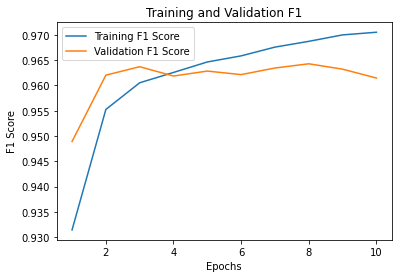

In [28]:
MLM_pretrain_model = rob_fit_synth_pretrain_model(MLM_model,tokenize.x_pretrain_train,tokenize.y_pretrain_train,
                                               tokenize.x_pretrain_val,tokenize.y_pretrain_val,
                                              epoch_num = 10, learning = 0.00005,layers=2)

MLM_pretrain_model.summary()

MLM_model.summary()

drive.mount('/content/drive',force_remount=True)


In [29]:
MLM_pretrain_model.save("/content/drive/My Drive/266-NLP-data/MLM_roberta_synth_pretrained_100K")
print(MLM_pretrain_model.evaluate(x=[tokenize.x_test.input_ids, tokenize.x_test.attention_mask], y = tokenize.y_test,  return_dict=True))

INFO:tensorflow:Assets written to: /content/drive/My Drive/266-NLP-data/MLM_roberta_synth_pretrained_100K/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/266-NLP-data/MLM_roberta_synth_pretrained_100K/assets


7/7 [==============================] - 1s 145ms/step - loss: 0.6761 - accuracy: 0.9467 - precision_1: 0.3978 - recall_1: 0.2984 - custom_f1: 0.2948
{'loss': 0.6761210560798645, 'accuracy': 0.9467061161994934, 'precision_1': 0.3978494703769684, 'recall_1': 0.2983871102333069, 'custom_f1': 0.2948145568370819}


### Fine tune train on our tagged data


Epoch 1/50
31/31 [==============================] - 12s 395ms/step - loss: 0.2351 - accuracy: 0.9484 - precision_1: 0.3547 - recall_1: 0.0575 - custom_f1: 0.0938 - val_loss: 0.1857 - val_accuracy: 0.9479 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_custom_f1: 0.0263
Epoch 2/50
31/31 [==============================] - 12s 395ms/step - loss: 0.1691 - accuracy: 0.9507 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - custom_f1: 0.0218 - val_loss: 0.1830 - val_accuracy: 0.9481 - val_precision_1: 0.6667 - val_recall_1: 0.0068 - val_custom_f1: 0.0389
Epoch 3/50
31/31 [==============================] - 12s 400ms/step - loss: 0.1644 - accuracy: 0.9509 - precision_1: 0.6098 - recall_1: 0.0113 - custom_f1: 0.0444 - val_loss: 0.1801 - val_accuracy: 0.9488 - val_precision_1: 0.7778 - val_recall_1: 0.0239 - val_custom_f1: 0.0702
Epoch 4/50
31/31 [==============================] - 13s 405ms/step - loss: 0.1615 - accuracy: 0.9511 - precision_1: 0.5820 - recall_1: 0.0321 - custom_f1

{'accuracy': 0.9409696459770203,
 'custom_f1': 0.19911286234855652,
 'loss': 0.4028524160385132,
 'precision_1': 0.2926829159259796,
 'recall_1': 0.19354838132858276}

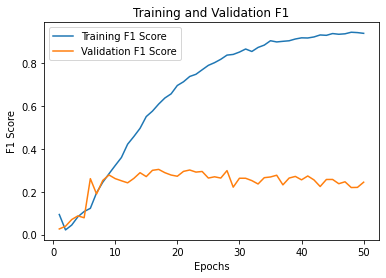

In [30]:
# reset epocs ~ 50
rob_fit_eval_model(MLM_pretrain_model,
                   tokenize.x_train,tokenize.y_train,
                   tokenize.x_val, tokenize.y_val,
                   tokenize.x_test, tokenize.y_test,
                   epoch_num = 50)

In [31]:
print(MLM_pretrain_model.evaluate(x=[tokenize.x_test.input_ids, tokenize.x_test.attention_mask], y = tokenize.y_test,  return_dict=True))

print(MLM_pretrain_model.evaluate(x=[tokenize.x_train.input_ids,tokenize. x_train.attention_mask], y = tokenize.y_train,  return_dict=True))
print(MLM_pretrain_model.evaluate(x=[tokenize.x_val.input_ids,tokenize. x_val.attention_mask], y = tokenize.y_val,  return_dict=True))

7/7 [==============================] - 1s 153ms/step - loss: 0.4029 - accuracy: 0.9410 - precision_1: 0.2927 - recall_1: 0.1935 - custom_f1: 0.1991
{'loss': 0.4028524160385132, 'accuracy': 0.9409696459770203, 'precision_1': 0.2926829159259796, 'recall_1': 0.19354838132858276, 'custom_f1': 0.19911286234855652}
51/51 [==============================] - 9s 174ms/step - loss: -0.0521 - accuracy: 0.9982 - precision_1: 0.9901 - recall_1: 0.9995 - custom_f1: 0.9949
{'loss': -0.052113957703113556, 'accuracy': 0.9981963634490967, 'precision_1': 0.9901389479637146, 'recall_1': 0.9995474815368652, 'custom_f1': 0.9949474930763245}
7/7 [==============================] - 1s 163ms/step - loss: 0.4385 - accuracy: 0.9375 - precision_1: 0.3393 - recall_1: 0.1945 - custom_f1: 0.2229
{'loss': 0.43845924735069275, 'accuracy': 0.9374555349349976, 'precision_1': 0.3392857015132904, 'recall_1': 0.19453924894332886, 'custom_f1': 0.2228834331035614}


## Final pass with Chandni's best hyperparameters

In [33]:
best_learning = .000005 
best_batch_size = 53
best_epochs = 15

loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer=tf.keras.optimizers.Adam(best_learning)



### Just synth data

Epoch 1/15


31/31 [==============================] - 22s 486ms/step - loss: -0.0220 - accuracy: 0.9930 - precision_2: 0.9600 - recall_2: 0.9231 - custom_f1: 0.9411 - val_loss: 0.4097 - val_accuracy: 0.9371 - val_precision_2: 0.3314 - val_recall_2: 0.1980 - val_custom_f1: 0.2537
Epoch 2/15
31/31 [==============================] - 12s 394ms/step - loss: -0.0235 - accuracy: 0.9936 - precision_2: 0.9630 - recall_2: 0.9312 - custom_f1: 0.9468 - val_loss: 0.4102 - val_accuracy: 0.9382 - val_precision_2: 0.3432 - val_recall_2: 0.1980 - val_custom_f1: 0.2529
Epoch 3/15
31/31 [==============================] - 12s 397ms/step - loss: -0.0239 - accuracy: 0.9935 - precision_2: 0.9687 - recall_2: 0.9231 - custom_f1: 0.9457 - val_loss: 0.4085 - val_accuracy: 0.9373 - val_precision_2: 0.3371 - val_recall_2: 0.2048 - val_custom_f1: 0.2573
Epoch 4/15
31/31 [==============================] - 12s 403ms/step - loss: -0.0227 - accuracy: 0.9931 - precision_2: 0.9566 - recall_2: 0.9276 - custom_f1: 0.9387 - val_loss: 0.

{'accuracy': 0.9400444030761719,
 'custom_f1': 0.18859758973121643,
 'loss': 0.39555007219314575,
 'precision_2': 0.2738095223903656,
 'recall_2': 0.1854838728904724}

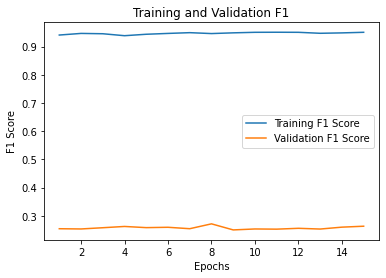

In [34]:
pretrain_model.compile(optimizer=optimizer,
                                 loss = loss,
                                 metrics=[tf.keras.metrics.BinaryAccuracy('accuracy'), 
                                          tf.keras.metrics.Precision(), 
                                          tf.keras.metrics.Recall(), 
                                          custom_f1])

rob_fit_eval_model(pretrain_model,
                   tokenize.x_train,tokenize.y_train,
                   tokenize.x_val, tokenize.y_val,
                   tokenize.x_test, tokenize.y_test,
                   epoch_num = best_epochs)

### Just MLM + synth data

Epoch 1/15


31/31 [==============================] - 31s 560ms/step - loss: -0.0360 - accuracy: 0.9937 - precision_4: 0.9653 - recall_4: 0.9321 - custom_f1: 0.9472 - val_loss: 0.4598 - val_accuracy: 0.9375 - val_precision_4: 0.3466 - val_recall_4: 0.2082 - val_custom_f1: 0.2604
Epoch 2/15
31/31 [==============================] - 13s 415ms/step - loss: -0.0371 - accuracy: 0.9944 - precision_4: 0.9697 - recall_4: 0.9425 - custom_f1: 0.9553 - val_loss: 0.4309 - val_accuracy: 0.9373 - val_precision_4: 0.3292 - val_recall_4: 0.1809 - val_custom_f1: 0.2327
Epoch 3/15
31/31 [==============================] - 13s 421ms/step - loss: -0.0395 - accuracy: 0.9945 - precision_4: 0.9729 - recall_4: 0.9416 - custom_f1: 0.9566 - val_loss: 0.4495 - val_accuracy: 0.9376 - val_precision_4: 0.3450 - val_recall_4: 0.2014 - val_custom_f1: 0.2523
Epoch 4/15
31/31 [==============================] - 13s 420ms/step - loss: -0.0411 - accuracy: 0.9944 - precision_4: 0.9697 - recall_4: 0.9421 - custom_f1: 0.9569 - val_loss: 0.

{'accuracy': 0.9405995011329651,
 'custom_f1': 0.19593797624111176,
 'loss': 0.4289369285106659,
 'precision_4': 0.28658536076545715,
 'recall_4': 0.1895161271095276}

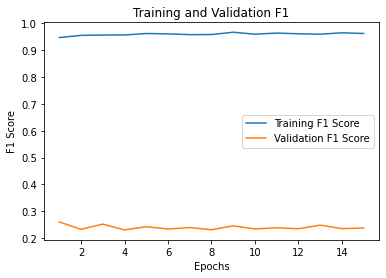

In [36]:
MLM_pretrain_model.compile(optimizer=optimizer,
                                 loss = loss,
                                 metrics=[tf.keras.metrics.BinaryAccuracy('accuracy'), 
                                          tf.keras.metrics.Precision(), 
                                          tf.keras.metrics.Recall(), 
                                          custom_f1])

rob_fit_eval_model(MLM_pretrain_model,
                   tokenize.x_train,tokenize.y_train,
                   tokenize.x_val, tokenize.y_val,
                   tokenize.x_test, tokenize.y_test,
                   epoch_num = best_epochs)